# LLM PROJECT - Preprocessing<p>
### Loading and EDA
First off, load in the data. I am doing the topic modeling task, so I need the `SetFit/20_newsgroups` dataset.

In [9]:
from datasets import load_dataset

In [11]:
ds = load_dataset('SetFit/20_newsgroups')

README.md:   0%|          | 0.00/734 [00:00<?, ?B/s]

c:\Users\mebar\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mebar\.cache\huggingface\hub\datasets--SetFit--20_newsgroups. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/8.91M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11314 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7532 [00:00<?, ? examples/s]

In [12]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 11314
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 7532
    })
})

There are two datasets withing the dictionary; a training set and a test set.

In [13]:
ds['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

In [14]:
ds['train'][0]

{'text': 'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 'label': 7,
 'label_text': 'rec.autos'}

In [15]:
ds['test'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

In [16]:
ds['test'][0]

{'text': 'I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.',
 'label': 7,
 'label_text': 'rec.autos'}

Rows consist of the text, the category number and the categroy label.

In [17]:
import pandas as pd
ds_train = pd.DataFrame(ds['train'])
ds_test = pd.DataFrame(ds['test'])

In [18]:
print('train:',ds_train.shape)
print('test:',ds_test.shape)

train: (11314, 3)
test: (7532, 3)


In [19]:
display(ds_train.head(3))
display(ds_test.head(3))

,text,label,label_text
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware


,text,label,label_text
0,I am a little confused on all of the models of...,7,rec.autos
1,I'm not familiar at all with the format of the...,5,comp.windows.x
2,"\nIn a word, yes.\n",0,alt.atheism


Having a look at what labels are in each set to make sure they are all present in both (which they should be, seeing as there are almost 20k samples) -

In [20]:
display(ds_train[['label','label_text']].value_counts().sort_index())
display(ds_test[['label','label_text']].value_counts().sort_index())

label  label_text              
0      alt.atheism                 480
1      comp.graphics               584
2      comp.os.ms-windows.misc     591
3      comp.sys.ibm.pc.hardware    590
4      comp.sys.mac.hardware       578
5      comp.windows.x              593
6      misc.forsale                585
7      rec.autos                   594
8      rec.motorcycles             598
9      rec.sport.baseball          597
10     rec.sport.hockey            600
11     sci.crypt                   595
12     sci.electronics             591
13     sci.med                     594
14     sci.space                   593
15     soc.religion.christian      599
16     talk.politics.guns          546
17     talk.politics.mideast       564
18     talk.politics.misc          465
19     talk.religion.misc          377
Name: count, dtype: int64

label  label_text              
0      alt.atheism                 319
1      comp.graphics               389
2      comp.os.ms-windows.misc     394
3      comp.sys.ibm.pc.hardware    392
4      comp.sys.mac.hardware       385
5      comp.windows.x              395
6      misc.forsale                390
7      rec.autos                   396
8      rec.motorcycles             398
9      rec.sport.baseball          397
10     rec.sport.hockey            399
11     sci.crypt                   396
12     sci.electronics             393
13     sci.med                     396
14     sci.space                   394
15     soc.religion.christian      398
16     talk.politics.guns          364
17     talk.politics.mideast       376
18     talk.politics.misc          310
19     talk.religion.misc          251
Name: count, dtype: int64

All 20 categories are present in each set, but that is too many labels for building a simple classifier; too complex for the time and for my ability. But each label starts off with a broader categeory before breaking down into more granular ones, so I am going to use that to reduce the number of categories down to 7, like so:<ul>
- alt
- comp
- misc
- rec
- sci
- soc
- talk

In [21]:
# mapping label_text column to values for new column
topic_map = {'alt.atheism': 0,

'comp.graphics': 1,
'comp.os.ms-windows.misc': 1,
'comp.sys.ibm.pc.hardware': 1,
'comp.sys.mac.hardware': 1,
'comp.windows.x': 1,

'misc.forsale': 2,

'rec.autos': 3,
'rec.motorcycles': 3,
'rec.sport.baseball': 3,
'rec.sport.hockey': 3,

'sci.crypt': 4,
'sci.electronics': 4,
'sci.med': 4,
'sci.space': 4,

'soc.religion.christian': 5,

'talk.politics.guns': 6,
'talk.politics.mideast': 6,
'talk.politics.misc': 6,
'talk.religion.misc': 6}

In [22]:
# creating new column 'simple_topic' based on mapping
ds_train['simple_topic'] = ds_train['label_text'].map(topic_map)
ds_test['simple_topic'] = ds_test['label_text'].map(topic_map)

In [23]:
# show heads of tables
display(ds_train.head(2))
display(ds_test.head(2))

,text,label,label_text,simple_topic
0,I was wondering if anyone out there could enli...,7,rec.autos,3
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware,1


,text,label,label_text,simple_topic
0,I am a little confused on all of the models of...,7,rec.autos,3
1,I'm not familiar at all with the format of the...,5,comp.windows.x,1


In [24]:
import matplotlib.pyplot as plt
import numpy as np

([<matplotlib.axis.YTick at 0x2167897b680>,
 [Text(0, 0, '0'),
  Text(0, 100, '100'),
  Text(0, 200, '200'),
  Text(0, 300, '300'),
  Text(0, 400, '400'),
  Text(0, 500, '500'),
  Text(0, 600, '600')])

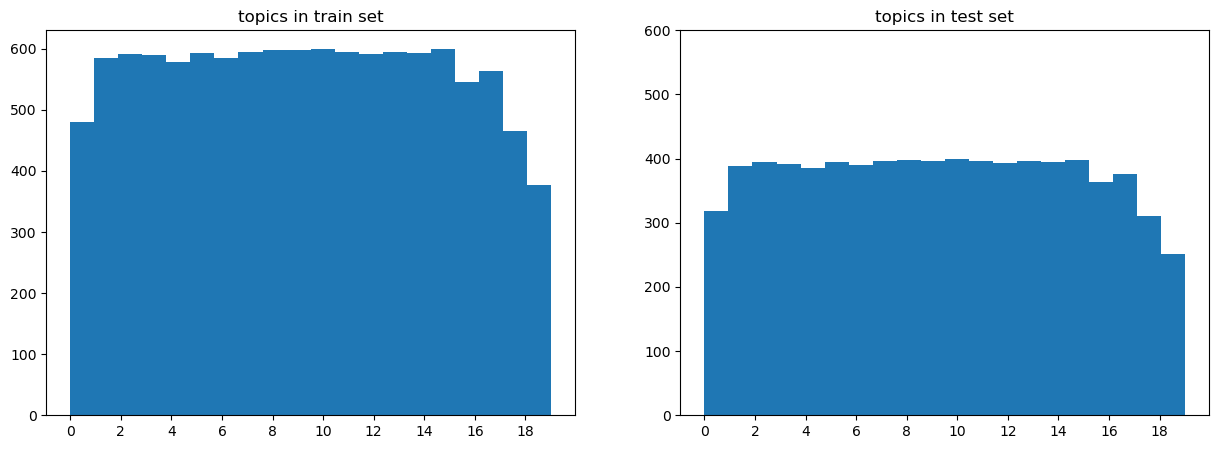

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ds_train['label'],bins=20)
plt.title('topics in train set')
plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,650,100))

plt.subplot(1,2,2)
plt.hist(ds_test['label'],bins=20)
plt.title('topics in test set')
plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,650,100))


([<matplotlib.axis.YTick at 0x2167c90b800>,
 [Text(0, 0, '0'),
  Text(0, 500, '500'),
  Text(0, 1000, '1000'),
  Text(0, 1500, '1500'),
  Text(0, 2000, '2000'),
  Text(0, 2500, '2500'),
  Text(0, 3000, '3000')])

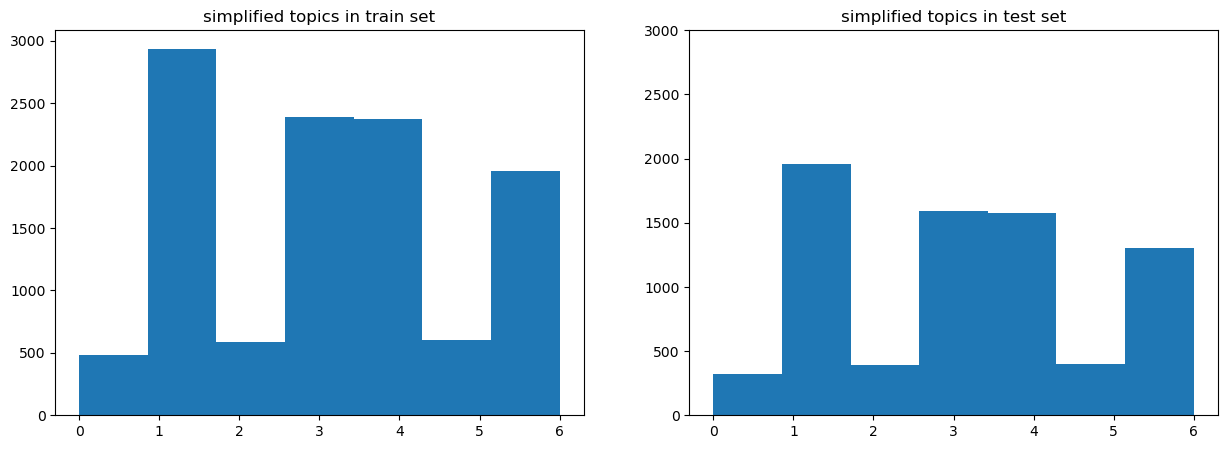

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ds_train['simple_topic'],bins=7)
plt.title('simplified topics in train set')
plt.yticks(np.arange(0,3200,500))

plt.subplot(1,2,2)
plt.hist(ds_test['simple_topic'],bins=7)
plt.title('simplified topics in test set')
plt.yticks(np.arange(0,3200,500))

Changing how the topics are grouped messed up the uniformity of the distribution, which makes sense as not every broad category had the same number of sub-categories to feed into it. This could present a problem with those categories being under selected by model prediction after training. 

### Preprocessing proper<p>
There are several things that need to be removed from the text entries to make them easier to process. All of this will be done in a new column, so that the original text is still accessible for reference. 

In [33]:
# create new column, remove newlines
ds_train['preprocess'] = ds_train['text'].str.replace('\n',' ')
ds_test['preprocess'] = ds_test['text'].str.replace('\n',' ')

In [34]:
# remove HTML tags
import re

def remove_html(text):
    clean_text = re.sub('<.*?>', '', text)
    return clean_text


ds_train['preprocess'] = ds_train['preprocess'].apply(lambda x: remove_html(x))
ds_test['preprocess'] = ds_test['preprocess'].apply(lambda x: remove_html(x))

In [35]:
# remove URLs
def remove_urls(text):
    clean_text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return clean_text


ds_train['preprocess'] = ds_train['preprocess'].apply(lambda x: remove_urls(x))
ds_test['preprocess'] = ds_test['preprocess'].apply(lambda x: remove_urls(x))

In [36]:
# remove emails
def remove_emails(text):
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'
    cleaned_text = re.sub(email_pattern, '', text)
    return cleaned_text


ds_train['preprocess'] = ds_train['preprocess'].apply(lambda x: remove_emails(x))
ds_test['preprocess'] = ds_test['preprocess'].apply(lambda x: remove_emails(x))

In [37]:
# remove punctuation
import string

def remove_punctuation(text):
  cleaned_text = text.translate(str.maketrans("", "", string.punctuation))
  return cleaned_text


ds_train['preprocess'] = ds_train['preprocess'].apply(lambda x: remove_punctuation(x))
ds_test['preprocess'] = ds_test['preprocess'].apply(lambda x: remove_punctuation(x))

In [38]:
# convert to lowercase
ds_train['preprocess'] = ds_train['preprocess'].str.lower()
ds_test['preprocess'] = ds_test['preprocess'].str.lower()

I want to see how much of a difference there is between keeping stopwords and dropping them, at least for the basic SKLearn model, so I am going to create another column now for that process. 

In [39]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mebar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mebar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [40]:
# create new column, drop stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)


ds_train['no_stopword'] = ds_train['preprocess'].apply(lambda x: remove_stopwords(x))
ds_test['no_stopword'] = ds_test['preprocess'].apply(lambda x: remove_stopwords(x))

To compare the differences, below are outputs from an entry which required a lot of processing at each step; unprocessed, containing stopwords, and without stopwords.

In [43]:
ds_train['text'][4]

"From article <C5owCB.n3p@world.std.com>, by tombaker@world.std.com (Tom A Baker):\n\n\nMy understanding is that the 'expected errors' are basically\nknown bugs in the warning system software - things are checked\nthat don't have the right values in yet because they aren't\nset till after launch, and suchlike. Rather than fix the code\nand possibly introduce new bugs, they just tell the crew\n'ok, if you see a warning no. 213 before liftoff, ignore it'."

In [42]:
ds_train['preprocess'][4]

'from article  by  tom a baker   my understanding is that the expected errors are basically known bugs in the warning system software  things are checked that dont have the right values in yet because they arent set till after launch and suchlike rather than fix the code and possibly introduce new bugs they just tell the crew ok if you see a warning no 213 before liftoff ignore it'

In [41]:
ds_train['no_stopword'][4]

'article tom baker understanding expected errors basically known bugs warning system software things checked dont right values yet arent set till launch suchlike rather fix code possibly introduce new bugs tell crew ok see warning 213 liftoff ignore'

Checking the total number of unique words: 

In [44]:
all_words_train_pre = []
for row in ds_train['preprocess']:
  tokens = word_tokenize(row)
  all_words_train_pre += tokens

In [45]:
all_words_train_no = []
for row in ds_train['no_stopword']:
  tokens = word_tokenize(row)
  all_words_train_no += tokens

In [46]:
all_words_test_pre = []
for row in ds_test['preprocess']:
  tokens = word_tokenize(row)
  all_words_test_pre += tokens

In [47]:
all_words_test_no = []
for row in ds_test['no_stopword']:
  tokens = word_tokenize(row)
  all_words_test_no += tokens

In [48]:
print('train, with stopwords:\ntotal:',len(all_words_train_pre),', unique:',len(set(all_words_train_pre)))
print('\ntrain, no stopwords:\ntotal:',len(all_words_train_no),', unique:',len(set(all_words_train_no)))
print('\ntest, with stopwords:\ntotal:',len(all_words_test_pre),', unique:',len(set(all_words_test_pre)))
print('\ntest, no stopwords:\ntotal:',len(all_words_test_no),', unique:',len(set(all_words_test_no)))

train, with stopwords:
total: 2036545 , unique: 94761

train, no stopwords:
total: 1150420 , unique: 94622

test, with stopwords:
total: 1285775 , unique: 68554

test, no stopwords:
total: 723349 , unique: 68415


The fact that the count of unique words does not change very much between the counts with stopwords included and without stopwords included tells us that there is a high variety of vocabulary present across the samples. 